In [24]:
import xarray as xr
import glob
import netCDF4 as nc
import numpy as np
import socket
import json
import os
import sys

import xmitgcm as xm

import matplotlib.pyplot as plt

# Get the path to the parent folder (one level up)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), '../..'))
print(parent_folder)

# Add the parent folder to sys.path
sys.path.append(parent_folder)
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config
#%matplotlib notebook
# seaborn for interactive plots or bokee or hvplot

/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results


In [25]:
model = 'test_zurich'
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('..//config.json', model)

In [36]:
ds_to_plot = ds_to_plot.isel(YG=range(0,54), YC=range(0,54))

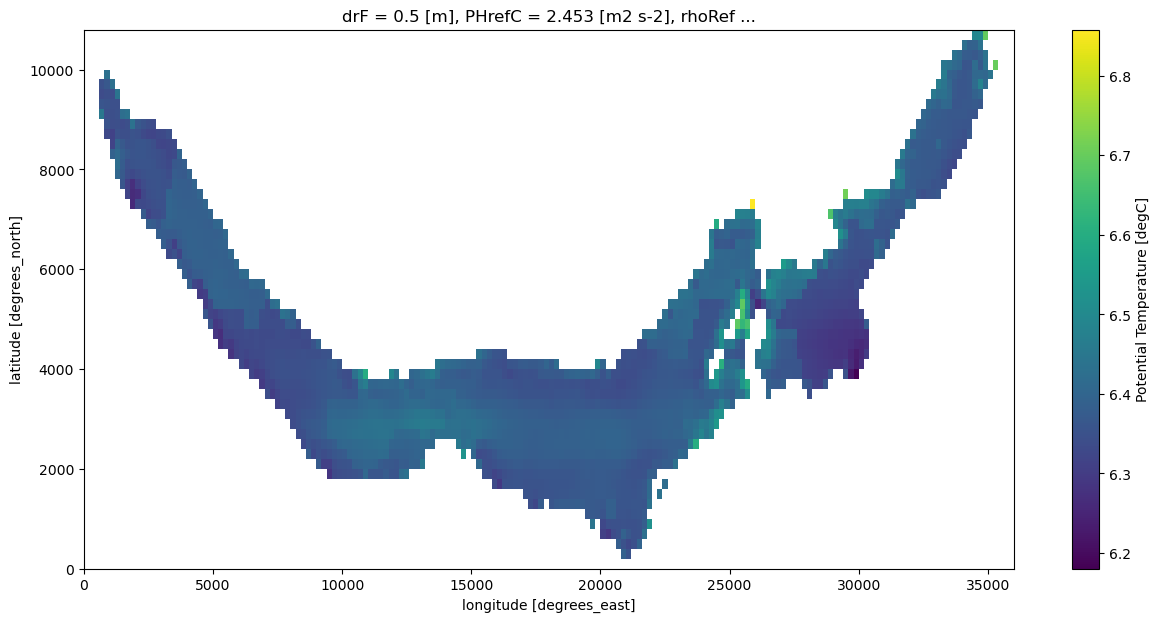

In [38]:
plt.close('all')
plt.figure(figsize=(15,7))
ds_sel = ds_to_plot['THETA'].isel(Z=0, time=-1)
ds_sel.where(ds_sel != 0, np.nan).plot()
plt.show()

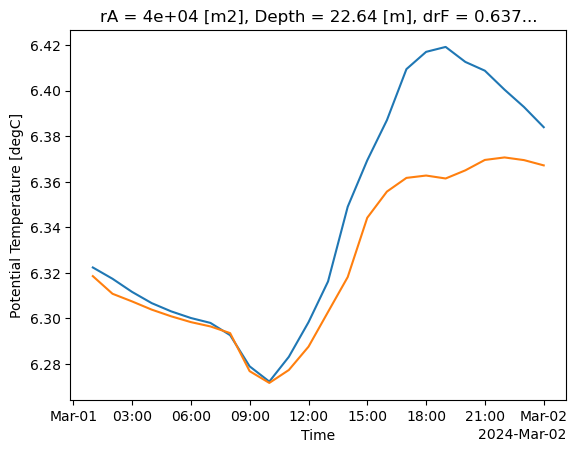

In [47]:
plt.close('all')
plt.figure()
ds_to_plot['THETA'].sel(XC=20000, YC=3000, Z=0, method='nearest').plot()
ds_to_plot['THETA'].sel(XC=20000, YC=3000, Z=-5, method='nearest').plot()
plt.show()

In [50]:
def plot_map(i_time: int, i_depth: int):
    plt.ioff()
    plt.close()
    fig, ax = plt.subplots(figsize=(9,3))
    
    T_plot = ds_to_plot['time'].values[i_time]
    Z_plot = ds_to_plot['Z'].values[i_depth]
    xr_plot = ds_to_plot['THETA'].sel(time=T_plot, Z=Z_plot)
    xr_plot = xr_plot.where(xr_plot != 0, np.nan)
    xr_plot.plot(cmap='jet', vmin=5, vmax=7)
    plt.axis('equal')
    
    subsetting_factor = 6
    X_trimmed = ds_to_plot['XC'][::subsetting_factor]
    Y_trimmed = ds_to_plot['YC'][::subsetting_factor]
    U_trimmed = ds_to_plot['UVEL'].sel(time=T_plot, Z=Z_plot)[:,1:][::subsetting_factor,::subsetting_factor]
    V_trimmed = ds_to_plot['VVEL'].sel(time=T_plot, Z=Z_plot)[1:,:][::subsetting_factor,::subsetting_factor]
    
    U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
    V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
    plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=7)
    
    #plt.xlim(37500,42500)
    #plt.ylim(19500,24500)
    
    plt.text(0.02, 0.98, f'{np.datetime_as_string(T_plot, unit="s").replace("T", " ")}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.text(0.02, 0.9, f'Z={Z_plot}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title('')
    
    # Remove axis, ticks, labels, and title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return plt.gcf()

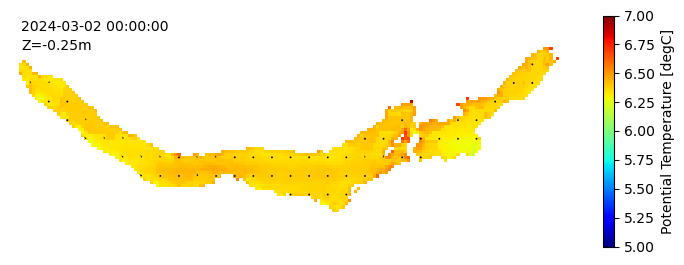

In [51]:
i_time = -1
i_depth = 0
plot_map(i_time, i_depth)

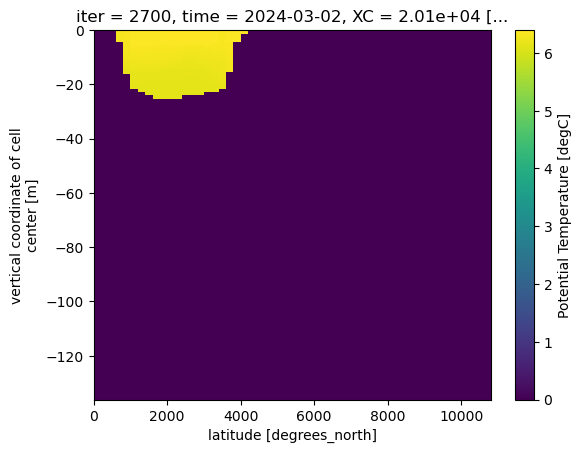

In [53]:
ds_to_plot['THETA'].isel(time=i_time).sel(XC=20000, method='nearest').plot()
plt.show()